In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from typing import Callable

import numpy as np
import pandas_datareader.data as web


### **Import the Data and Visualise the Order Book**

In [ ]:
# Retrieve 4 hours worth of data
def get_data():
  data = pd.read_csv("http://16.16.215.98:5000/", names = ["Date", "Order_ID", "Price", "Quantity", "Ask/Bid"])
  return data

data = get_data()

# Ask price is 0, while Bid price is 1
cleanup_askbid = { "Ask/Bid": { "0_ask":0, "0_bid":1 } }

df = data.replace(cleanup_askbid)
df.sort_values(by=["Ask/Bid"])
df

,Date,Order_ID,Price,Quantity,Ask/Bid
0,2024-02-01 15:31:54,1,2302.2,17.042492,0
1,2024-02-01 15:31:54,632,2301.9,6.389237,1
2,2024-02-01 15:31:55,1,2302.2,17.042492,0
3,2024-02-01 15:31:55,632,2301.9,6.389237,1
4,2024-02-01 15:31:56,1,2302.2,3.257799,0
...,...,...,...,...,...
40829,2024-02-01 21:15:05,592,2304.8,0.000008,1
40830,2024-02-01 21:15:06,1,2304.9,0.278973,0
40831,2024-02-01 21:15:06,588,2304.8,0.000008,1
40832,2024-02-01 21:15:07,1,2304.9,2.527920,0


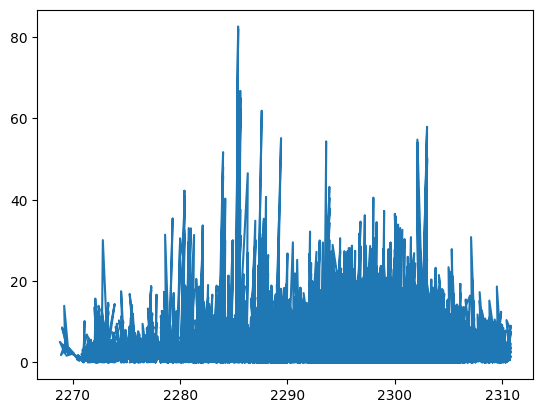

In [ ]:
plt.plot(df['Price'], df['Quantity'])

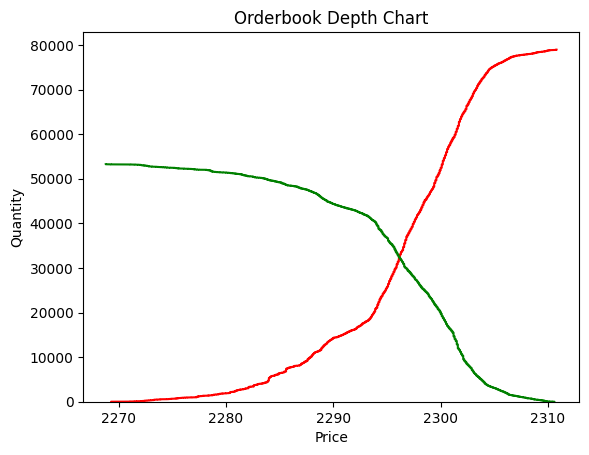

In [ ]:
# Plot the orderbook data

# Asks
asks = df.loc[df["Ask/Bid"] == 0 ]
ask_price = asks["Price"]
ask_qty = asks["Quantity"]

# Bids
bids = df.loc[df["Ask/Bid"] == 1 ]
bid_price = bids["Price"]
bid_qty = bids["Quantity"]

ask_df = pd.DataFrame({'price': ask_price, 'quantity': ask_qty})
bid_df = pd.DataFrame({'price': bid_price, 'quantity': bid_qty})

# Plot
fig, ax = plt.subplots()
sns.ecdfplot(x="price", weights="quantity", stat="count", data=ask_df, ax=ax, color="red")
sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bid_df, ax=ax, color="green")

ax.set_title("Orderbook Depth Chart", size=12)
ax.set_xlabel("Price")
ax.set_ylabel("Quantity")

plt.show()

### **Convert the Orderbook to OHLC Format**


*   OHLC shows the open, high, low, and close price for the given period of data.
*   Focuses on the volatility of the price during hours of the financial market but may be applied to orderbooks in certain scenarios.


In [ ]:
data = df

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data

,Order_ID,Price,Quantity,Ask/Bid
Date,,,,
2024-02-01 15:31:54,1,2302.2,17.042492,0
2024-02-01 15:31:54,632,2301.9,6.389237,1
2024-02-01 15:31:55,1,2302.2,17.042492,0
2024-02-01 15:31:55,632,2301.9,6.389237,1
2024-02-01 15:31:56,1,2302.2,3.257799,0
...,...,...,...,...
2024-02-01 21:15:05,592,2304.8,0.000008,1
2024-02-01 21:15:06,1,2304.9,0.278973,0
2024-02-01 21:15:06,588,2304.8,0.000008,1


In [ ]:
# Resample the price and quantity columns into 1 minute bars
resample_price = data.Price.resample('60s').ohlc()
resample_quantity = data.Quantity.resample('60s').sum()

resample_price

,open,high,low,close
Date,,,,
2024-02-01 15:31:00,2302.2,2302.2,2301.8,2302.0
2024-02-01 15:32:00,2302.1,2302.3,2298.5,2298.7
2024-02-01 15:33:00,2299.5,2300.5,2298.6,2299.6
2024-02-01 15:34:00,2299.8,2300.9,2299.1,2300.2
2024-02-01 15:35:00,2300.3,2301.0,2299.4,2299.7
...,...,...,...,...
2024-02-01 21:11:00,2306.1,2306.7,2301.0,2301.0
2024-02-01 21:12:00,2301.0,2304.2,2300.6,2303.9
2024-02-01 21:13:00,2304.1,2304.1,2301.5,2303.7


In [ ]:
# Calculate MACD - MACD is used to find "crossover signals" that display trends and changes in prices.
# If the MACD crosses ABOVE the signal line, this suggests a BUY
# If the MACD crosses BELOW the signal line, this suggests SELL
# Formula credits:
# 1. https://dayanand-shah.medium.com/exponential-moving-average-and-implementation-with-python-1890d1b880e6
# 2. https://medium.com/@financial_python/building-a-macd-indicator-in-python-190b2a4c1777

# EMA of 12-period
resample_price['EMA12'] = resample_price['close'].ewm(span=12, adjust=False).mean()

# 26-period EMA
resample_price['EMA26'] = resample_price['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD
resample_price['MACD'] = resample_price['EMA12'] - resample_price['EMA26']

# Calculate Signal Line - 9-period
resample_price['Signal_Line'] = resample_price['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
last_row = resample_price.iloc[-1]
second_last_row = resample_price.iloc[-2]

if second_last_row['MACD'] > second_last_row['Signal_Line'] and last_row['MACD'] < last_row['Signal_Line']:
    print('Cross Below Signal Line')
elif second_last_row['MACD'] < second_last_row['Signal_Line'] and last_row['MACD'] > last_row['Signal_Line']:
    print('Cross Above Signal Line')
else:
    print('No Crossover')

No Crossover


### **Testing RSI Strategy**

RSI is the Relative Strength Index

*   The index value is between zero and 100.
*   Overbought when RSI > 70
*   Oversold when RSI < 30
*   Here I generate two signals:
    1. Divergence: when the price moves opposite to RSI
    2. Failure swing: when (1) the RSI < 30, (2) then RSI > 30, (3) then back down but NOT < 30, (4) then goes higher than previous high (2)
* In a bull market - prices expected to increase - RSI maintains a value between 40 to 90.
* In a bear market - prices expected to decline - RSI maintains a value between 10 - 60.


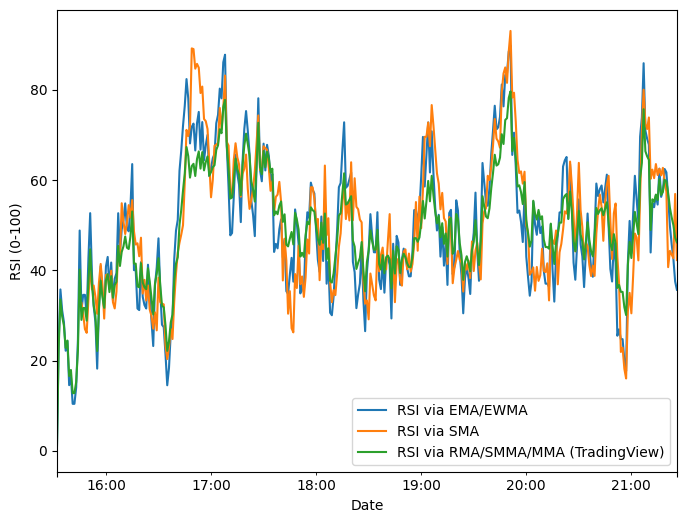

In [ ]:
# Get data
data =  get_data()
cleanup_askbid = { "Ask/Bid": { "0_ask":0, "0_bid":1 } }
data = data.replace(cleanup_askbid)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Resample the price and quantity columns into 1 minute bars
resample_price = data.Price.resample('60s').ohlc()
resample_quantity = data.Quantity.resample('60s').sum()
close = resample_price['close']

# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    window_length = 14
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:]

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[window_length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()

    return rsi

# Window length for moving average
window_length = 14

# Calculate RSI using MA of choice
rsi_ema = calc_rsi(close, lambda s: s.ewm(span=window_length).mean())
rsi_sma = calc_rsi(close, lambda s: s.rolling(window_length).mean())
rsi_rma = calc_rsi(close, lambda s: s.ewm(alpha=1 / window_length).mean())

# Compare graphically
plt.figure(figsize=(8, 6))
rsi_ema.plot(), rsi_sma.plot(), rsi_rma.plot()
plt.legend(['RSI via EMA/EWMA', 'RSI via SMA', 'RSI via RMA/SMMA/MMA (TradingView)'])
plt.xlabel("Date")
plt.ylabel("RSI (0-100)")
plt.show()

In [ ]:
rsi_series = resample_price

# Change = close[i]-Change[i-1]
rsi_series["Change"] = (rsi_series["close"] - rsi_series["close"].shift(1)).fillna(0)

# Upword Movement
rsi_series["Upword Movement"] = (rsi_series["Change"][rsi_series["Change"] >0])
rsi_series["Upword Movement"] = rsi_series["Upword Movement"].fillna(0)

# Downword Movement
rsi_series["Downword Movement"] = (abs(rsi_series["Change"])[rsi_series["Change"] <0]).fillna(0)
rsi_series["Downword Movement"] = rsi_series["Downword Movement"].fillna(0)

#Average Upword Movement
# For first Upword Movement Mean of first n elements.
n = 5
rsi_series["Average Upword Movement"] = 0.00
rsi_series["Average Upword Movement"][n] = rsi_series["Upword Movement"][1:n+1].mean()

# For Second onwords
for i in range(n+1,len(rsi_series),1):
    #print(rsi_series["Average Upword Movement"][i-1],rsi_series["Upword Movement"][i])
    rsi_series["Average Upword Movement"][i] = (rsi_series["Average Upword Movement"][i-1]*(n-1)+rsi_series["Upword Movement"][i])/n

#Average Downword Movement
# For first Downword Movement Mean of first n elements.
rsi_series["Average Downword Movement"] = 0.00
rsi_series["Average Downword Movement"][n] = rsi_series["Downword Movement"][1:n+1].mean()

# For Second onwords
for i in range(n+1,len(rsi_series),1):
    #print(rsi_series["Average Downword Movement"][i-1],rsi_series["Downword Movement"][i])
    rsi_series["Average Downword Movement"][i] = (rsi_series["Average Downword Movement"][i-1]*(n-1)+rsi_series["Downword Movement"][i])/n

#Relative Index
rsi_series["Relative Strength"] = (rsi_series["Average Upword Movement"]/rsi_series["Average Downword Movement"]).fillna(0)

#RSI
rsi_series["RSI"] = 100 - 100/(rsi_series["Relative Strength"]+1)
print(rsi_series.round(2))

                       open    high     low   close  Change  Upword Movement  \
Date                                                                           
2024-02-01 15:31:00  2302.2  2302.2  2301.8  2302.0     0.0              0.0   
2024-02-01 15:32:00  2302.1  2302.3  2298.5  2298.7    -3.3              0.0   
2024-02-01 15:33:00  2299.5  2300.5  2298.6  2299.6     0.9              0.9   
2024-02-01 15:34:00  2299.8  2300.9  2299.1  2300.2     0.6              0.6   
2024-02-01 15:35:00  2300.3  2301.0  2299.4  2299.7    -0.5              0.0   
...                     ...     ...     ...     ...     ...              ...   
2024-02-01 21:22:00  2305.7  2305.7  2304.4  2304.6    -0.9              0.0   
2024-02-01 21:23:00  2304.8  2305.7  2303.8  2304.0    -0.6              0.0   
2024-02-01 21:24:00  2304.4  2304.7  2303.4  2303.5    -0.5              0.0   
2024-02-01 21:25:00  2303.8  2304.3  2302.5  2302.7    -0.8              0.0   
2024-02-01 21:26:00  2302.8  2303.4  230

In [ ]:
# Signals
def generate_signals(rsi_values):
    signals = []
    i = 0
    for rsi in rsi_values:
        if rsi > 70:
            signals.append(['SELL', rsi_values[i]])
        elif rsi < 30:
            signals.append(['BUY', rsi])
        else:
            signals.append(['HOLD', rsi])
        i = i + 1
    return signals

In [ ]:
signals = generate_signals(rsi_ema)
print(signals)

[['BUY', 0.0], ['BUY', 23.936170212766797], ['HOLD', 35.76364892881678], ['HOLD', 31.1119846463327], ['BUY', 28.54189375297912], ['BUY', 22.195183539901066], ['BUY', 24.35178534395321], ['BUY', 14.567680592305493], ['BUY', 16.4129421650088], ['BUY', 10.432792502015701], ['BUY', 10.432792502015701], ['BUY', 14.057969352778528], ['BUY', 24.61910487676296], ['HOLD', 48.81245299642038], ['HOLD', 31.01166121670694], ['HOLD', 34.56444425393725], ['HOLD', 34.56444425393725], ['BUY', 29.94494546737755], ['HOLD', 42.70687974300566], ['HOLD', 52.657991695928246], ['HOLD', 39.32184740183927], ['HOLD', 32.078297556490114], ['BUY', 28.513265182184682], ['BUY', 18.228359173790153], ['HOLD', 31.77968062164787], ['HOLD', 40.924294727229025], ['HOLD', 35.1654051537207], ['HOLD', 31.474482840720242], ['HOLD', 40.8431497215939], ['HOLD', 42.96034699899517], ['HOLD', 35.915389446840436], ['HOLD', 41.719408832037914], ['HOLD', 33.35407688719586], ['HOLD', 38.12586168180665], ['HOLD', 39.37792410166513], ['